# Preparations

In [1]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (10,8)

In [2]:
# Some parameters of the simulations to be analyzed
rounds = 50
vehicle_limit = 80

target_number_of_rounds = 15

all_routes = [[0, 3], [0, 1], [2, 3], [2, 1]]
sub_routes = [[0, 1], [2, 3]]

In [3]:
# Folder prefix
current_hier = "2.2"

## Preprocessing of `record`
The dataframe contains vehicle data recorded in each simulation round, including:
- the label assigned to each car (`Vehicle_label`)
- the routes taken (`Road_order`)
- the time spent to reach the end (`Total_time`)
- the label of the vehicle immediately in front of it in the corrdsponding road segment (`Leading_vehicles`)
- the amount of time it stopped (speed is 0) in the corresponding road segment (`Stopped_time`)

In [4]:
def preprocess_record(record, routes):
    # Since some column values are lists, they need to be preprocessed after importing the csv file to
    # avoid the lists being recognized as strings
    record['Road_order'] = record.apply(lambda row: ast.literal_eval(row['Road_order']), axis=1)

    # Add a column that maps a specific road combination (i.e., a route) to a "label", which is its position
    # in a list that shows all the possible routes
    record["Road_order_label"] = record.apply(lambda row: routes.index(row.Road_order), axis=1)
    return record

## Preprocessing of `utility`
The dataframe contains utility data computed based on the simulation outcome, including:
- the label assigned to each car (`Vehicle_label`)
- the utility value of each route as a list element (`Utilities`)
- the probability value of choosing each route in the next round as a list element (`Probabilities`)
- all the routes each car has chosen so far (`Routes_taken`)
- the interpolation between time and money for the driver (`Gamma`) for computing the time component of the utility value
- the risk aversion level of the driver (`Eta`) for deciding the formula of utility calculation

In [5]:
def preprocess_utility(utility):
    # Since some column values are lists, they need to be preprocessed after importing the csv file to
    # avoid the lists being recognized as strings
    utility['Routes_taken'] = utility.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
    utility['Probabilities'] = utility.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
    return utility

## Functions needed

In [7]:
def route_avg_time(ax, 
                   fig,
                   y_range,
                   record_df, 
                   number_of_routes):
    """
    Plot the average time to arrive grouped by each route and round.
    
    Parameters:
        y_range: specified lower and upper bound for the y axis
        record_df: dataframe that contains data recorded in the simulation
        number_of_routes: number of routes involved (number of lines to be plotted)
    """
    
    time_df = pd.pivot_table(record_df, values='Total_time', 
                             index=['Road_order_label', 'Round_number'], 
                             aggfunc=np.mean).reset_index(drop=False)
    plot_route_time = [[], [], [], []]

    for i in range(number_of_routes):
        times = time_df.loc[time_df.Road_order_label==i].sort_values('Round_number').Total_time.values
        plot_route_time[i]=times

    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_route_time[i], color=colors[i])

    ax.set_xlabel("Round")
    ax.set_ylabel("Average time to arrive (s)")
    ax.set_ylim(y_range[0], y_range[1])
 
    return ax

In [8]:
def route_taken_number(ax,
                       fig,
                       y_range,
                       utility_df, 
                       rounds, 
                       number_of_routes):
    """
    Plot the changes in number of vehicles that took the route over time.
    
    Parameters:
        y_range: specified lower and upper bound for the y axis
        utility_df: dataframe that contains utility data
        rounds: total number of rounds
        number_of_routes: number of routes involved (number of lines to be plotted)
    """
    
    route_df = pd.DataFrame(utility_df['Routes_taken'].to_list(), columns=range(rounds))
    plot_route_l = [[], [], [], []]

    for i in range(number_of_routes):
        for j in range(rounds):
            plot_route_l[i].append(len(route_df.loc[route_df[j]==i]))

    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_route_l[i], color=colors[i])
    
    ax.set_xlabel("Round")
    ax.set_ylabel("Number of vehicles")
    if number_of_routes == 4:
        ax.set_ylim(y_range[0], y_range[1])
    
    return ax

In [9]:
def route_chosen_probability(ax,
                             fig,
                             y_range,
                             rounds, 
                             number_of_routes,
                             folder_name):
    """
    Plot the changes in probabilities of choosing each route over time.    
    
    Parameters:
        y_range: specified lower and upper bound for the y axis
        rounds: number of rounds in utility_df
        number_of_routes: number of routes involved (number of lines to be plotted)
        folder_name: the folder that stores all the utility data files
    """
    
    plot_prob_l = [[], [], [], []]

    for r in range(1, rounds+1):
        df = pd.read_csv(f'{folder_name}/Saved_data/Utility_data/Round_{r}.csv')
        df['Probabilities'] = df.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
        
        for i in range(number_of_routes):
            avg_prob = pd.DataFrame(df['Probabilities'].to_list(), columns=range(number_of_routes))[i].mean()
            plot_prob_l[i].append(avg_prob)
            
    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_prob_l[i], color=colors[i])

    ax.set_xlabel("Round")
    ax.set_ylabel("Average probability")
    if number_of_routes == 4:
        ax.set_ylim(y_range[0], y_range[1])
    
    return ax

# Visualization

In [11]:
# Define the layout of how the subplots are placed
row, col = 5, 5
width, height = 20, 15

In [13]:
folder_names = [current_hier+".2 Lower eta", current_hier+".3 Higher eta", 
                current_hier+".1 Avg scenario", current_hier+".4 Lower gamma",
                current_hier+".5 Higher gamma"]
subfolder_names = []
for f in folder_names:
    subfolder_names.extend([f+"/"+f[:5]+".2 No connection", f+"/"+f[:5]+".1 Zero alpha",
                            f+"/"+f[:5]+".4 Small alpha", f+"/"+f[:5]+".3 Avg alpha", 
                            f+"/"+f[:5]+".5 Large alpha"])

## - The average time needed to reach destination by different routes
**Plot with each row representing a scenario and each column representing a case within the scenario**

In [34]:
y_ranges = [[40, 185], [40, 190],
            [40, 180], [40, 180],
            [40, 185]]

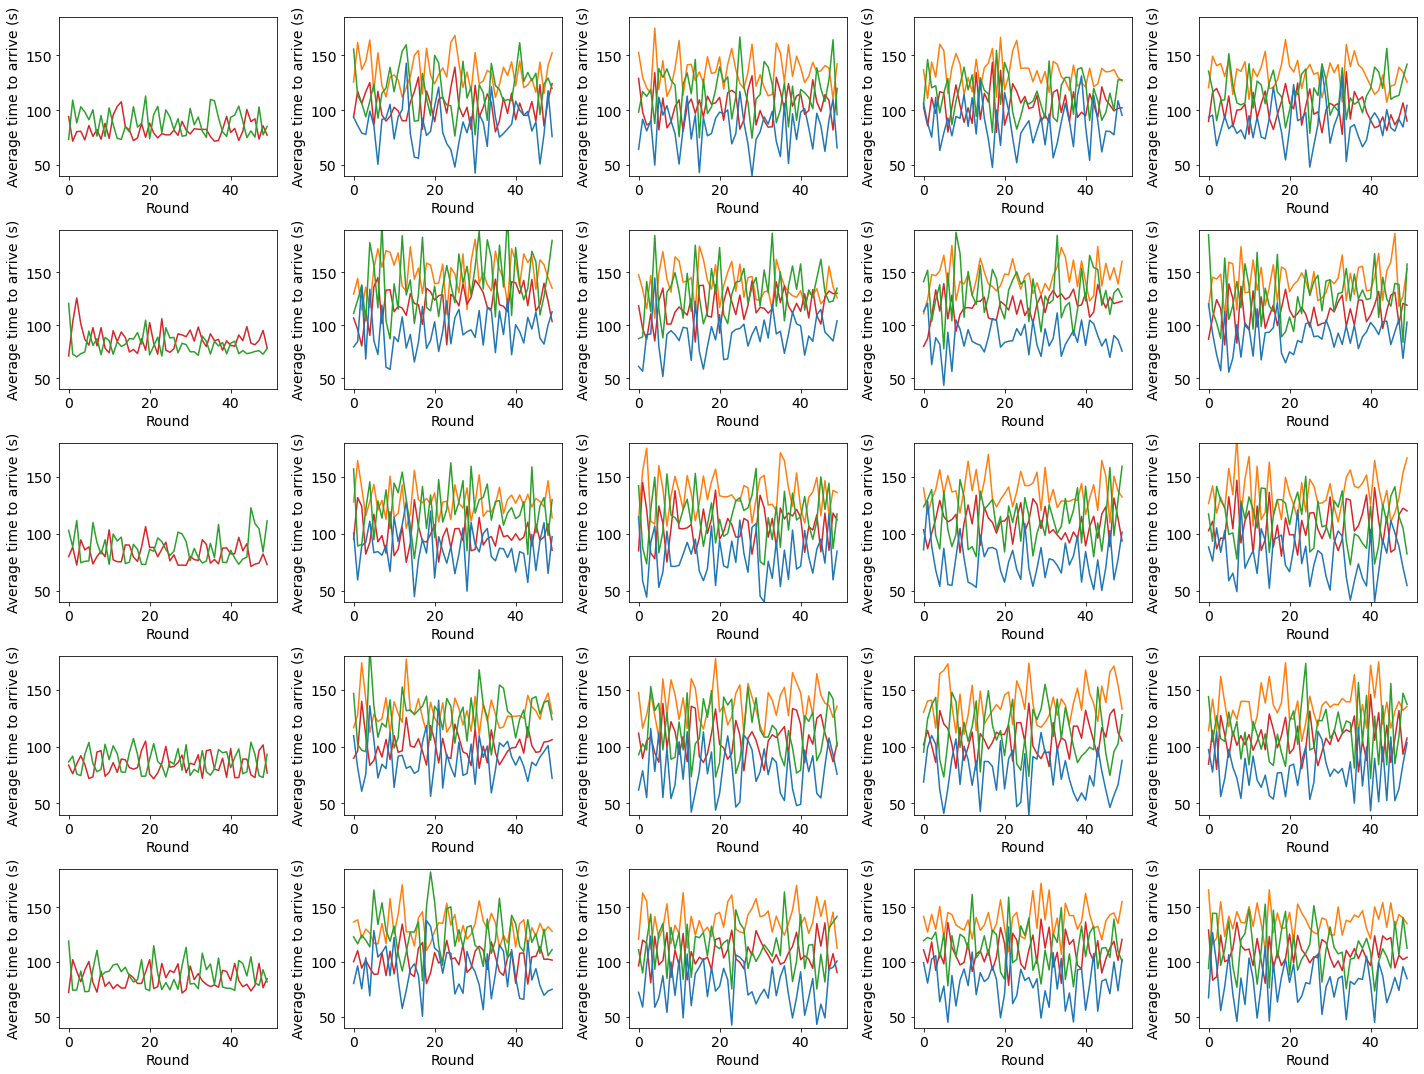

In [35]:
fig, axs = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(subfolder_names)):
    folder = subfolder_names[idx]
    record_df = pd.read_csv(f'{folder}/Saved_data/Simulation_records/Round_{rounds}.csv')
    record_df = preprocess_record(record_df, all_routes)

    ax = route_avg_time(axs[idx//col, idx%col], 
                        fig,
                        y_ranges[idx//col],
                        record_df=record_df, 
                        number_of_routes=len(all_routes)
                       )
    axs[idx//col, idx%col] = ax
    
plt.tight_layout()

plt.savefig("Analysis/Avg_time_by_route_rate27.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()

## - The number of vehicles that choose a route over time
**Plot with each row representing a scenario and each column representing a case within the scenario**

In [36]:
y_ranges = [[8, 35], [0, 50],
            [8, 35], [8, 40],
            [0, 40]]

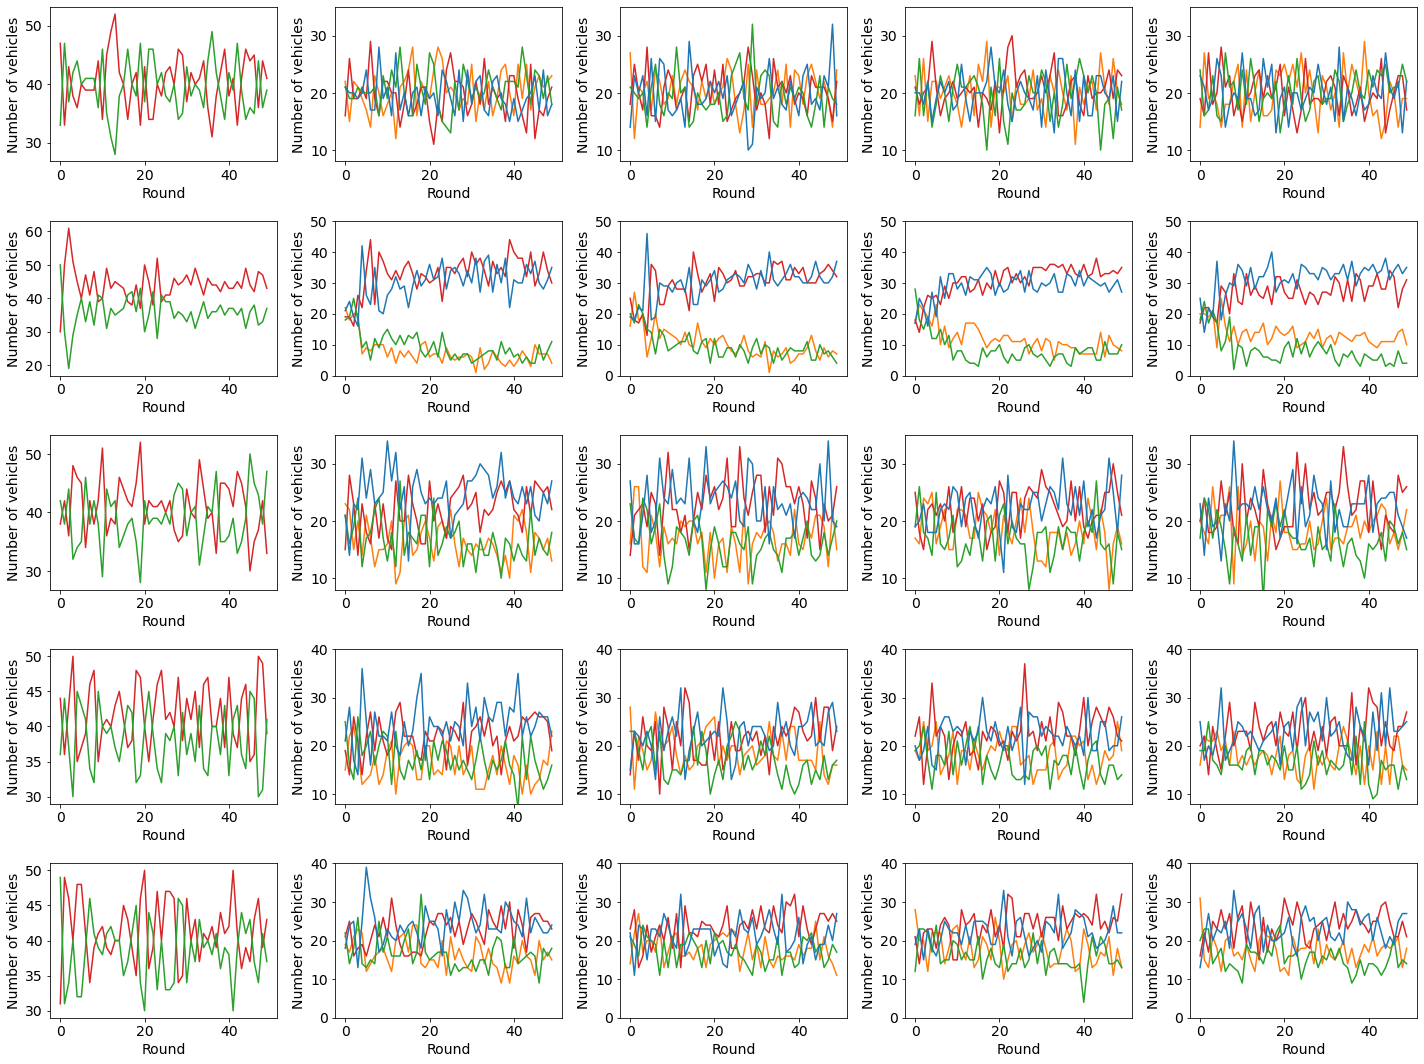

In [37]:
fig2, axs2 = plt.subplots(row, col, figsize=(width, height))

for idx in range(len(subfolder_names)):
    folder = subfolder_names[idx]
    utility_df = pd.read_csv(f'{folder}/Saved_data/Utility_data/Round_{rounds}.csv')
    utility_df = preprocess_utility(utility_df)
    
    if "No connection" in folder:
        ax = route_taken_number(axs2[idx//col, idx%col], 
                            fig2,
                            [20, 60],
                            utility_df,
                            rounds, 
                            len(sub_routes)
                           )
    else:
        ax = route_taken_number(axs2[idx//col, idx%col], 
                            fig2,
                            y_ranges[idx//col],
                            utility_df,
                            rounds, 
                            len(all_routes)
                           )
    
    
    axs2[idx//col, idx%col] = ax

plt.tight_layout()
plt.savefig("Analysis/Vehicle_number_by_route_rate27.png",
            bbox_inches='tight', pad_inches=0.25)
plt.show()

## - The probabilities of choosing different routes over time
**Plot with each row representing a scenario and each column representing a case within the scenario**

In [29]:
y_ranges = [[0.18, 0.32], [0, 0.58],
            [0.15, 0.4], [0.15, 0.4],
            [0.15, 0.38]]

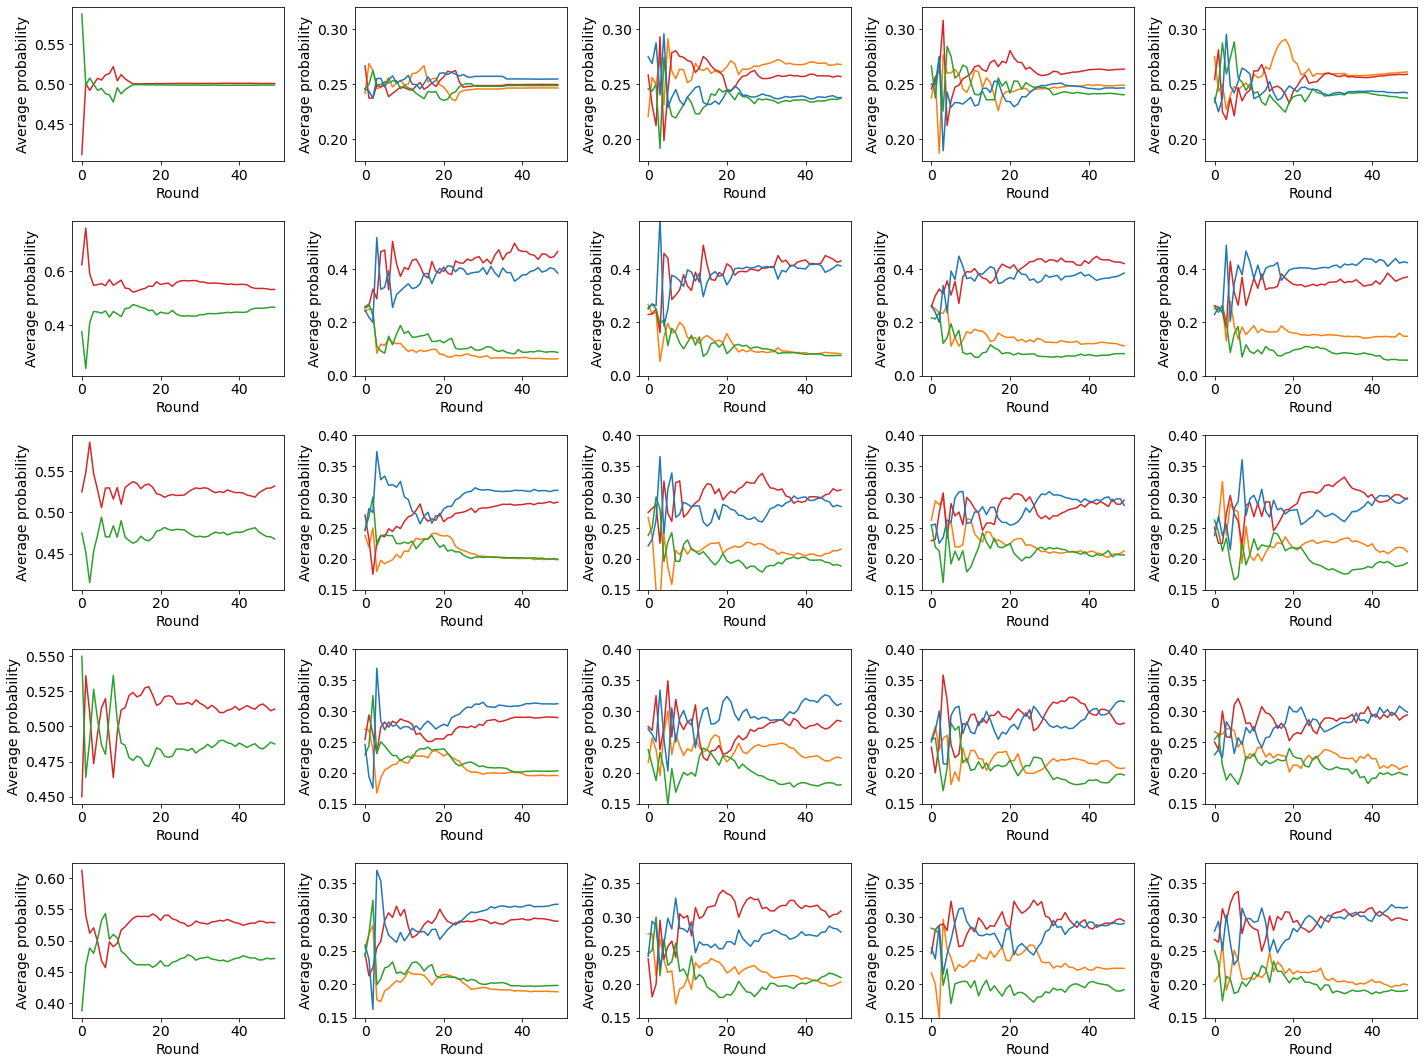

In [31]:
fig5, axs5 = plt.subplots(row, col, figsize=(width, height))


for idx in range(len(subfolder_names)):
    folder = subfolder_names[idx]
    
    if "No connection" in folder:
        ax = route_chosen_probability(axs5[idx//col, idx%col], 
                                      fig5,
                                      [0.4, 0.6],
                                      rounds,
                                      len(sub_routes),
                                      folder
                                     )
    else:
        ax = route_chosen_probability(axs5[idx//col, idx%col], 
                                      fig5,
                                      y_ranges[idx//col],
                                      rounds,
                                      len(all_routes),
                                      folder
                                     )
    
    
    axs5[idx//col, idx%col] = ax

plt.tight_layout()
plt.savefig("Analysis/Average_probability_by_route_rate27.png",
            bbox_inches = 'tight', pad_inches=0.25)
plt.show()